# **CIFAR dataset**

# **Importing Dependencies**

In [ ]:
import os
import cv2
import py7zr
import numpy as np
import pandas as pd
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings('ignore')

# **json file path configuration**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Downloading the file**

In [ ]:
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Extracting the ZIP file**

In [ ]:
dataset = '/content/cifar-10.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Extracting .7z file**

In [ ]:
archive = py7zr.SevenZipFile('/content/train.7z', mode='r')
archive.extractall()
archive.close()

In [ ]:
train_data_img = os.listdir('/content/train')

In [ ]:
type(train_data_img)

list

In [ ]:
len(train_data_img)

50000

In [ ]:
print(train_data_img[0:5])
print(train_data_img[-5:])

['39332.png', '19922.png', '37962.png', '46820.png', '39059.png']
['31014.png', '11071.png', '3424.png', '4331.png', '25893.png']


# **Loading the Label dataset**

In [ ]:
labels_df = pd.read_csv('/content/trainLabels.csv')

In [ ]:
labels_df.shape

(50000, 2)

In [ ]:
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


# **Getting the unique label value**

In [ ]:
labels_df['label'].unique()

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [ ]:
labels_df['label'].value_counts()

,count
label,
frog,5000
truck,5000
deer,5000
automobile,5000
bird,5000
horse,5000
ship,5000
cat,5000
dog,5000


### **So dataset is balanced**

# **Applying One Hot Encoding**

In [ ]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(labels_df['label'].values.reshape(-1,1)).toarray()

In [ ]:
print(labels[0:5])
print(labels[-5:])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


# **Displaying sample image**

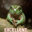

In [ ]:
img = cv2.imread('/content/train/5000.png')
cv2_imshow(img)

# **Making the list of Image's ID**

In [ ]:
id_list = list(labels_df['id'])

In [ ]:
print(id_list[0:5])
print(id_list[-5:])

[1, 2, 3, 4, 5]
[49996, 49997, 49998, 49999, 50000]


# **Convert images to numpy arrays**

In [ ]:
train_data_folder = '/content/train/'

data = []

for id in id_list:

  image = Image.open(train_data_folder + str(id) + '.png')
  image = np.array(image)
  data.append(image)

In [ ]:
type(data[0])

numpy.ndarray

# **Checking the shape of image**

In [ ]:
data[0].shape

(32, 32, 3)

# **Convert image list and label list to numpy arrays**

In [ ]:
X = np.array(data)
Y = np.array(labels)

In [ ]:
print(X.shape)
print(Y.shape)

(50000, 32, 32, 3)
(50000, 10)


# **Splitting into train-test data**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)


# **Scaling the data**

In [ ]:
X_train_scaled = X_train/255

X_test_scaled = X_test/255

# **Defining ResNet50**

In [ ]:
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

In [ ]:
num_of_classes = 10

model = models.Sequential([
    layers.UpSampling2D((2, 2)),
    layers.UpSampling2D((2, 2)),
    layers.UpSampling2D((2, 2)),
    convolutional_base,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_of_classes, activation='softmax')
])

In [ ]:
model(X_train_scaled[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.09941452, 0.15649971, 0.13915268, 0.01468363, 0.1650478 ,
        0.03310372, 0.05253417, 0.26150784, 0.012203  , 0.06585297]],
      dtype=float32)>

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=10)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 433s 331ms/step - accuracy: 0.3230 - loss: 2.0692 - val_accuracy: 0.7117 - val_loss: 0.9790
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 409s 333ms/step - accuracy: 0.6648 - loss: 1.0949 - val_accuracy: 0.8865 - val_loss: 0.4850
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 381s 332ms/step - accuracy: 0.7897 - loss: 0.7813 - val_accuracy: 0.9128 - val_loss: 0.3512
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 362s 322ms/step - accuracy: 0.8590 - loss: 0.5977 - val_accuracy: 0.9220 - val_loss: 0.3108
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 382s 322ms/step - accuracy: 0.9016 - loss: 0.4631 - val_accuracy: 0.9287 - val_loss: 0.2599
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 391s 330ms/step - accuracy: 0.9303 - loss: 0.3670 - val_accuracy: 0.9325 - val_loss: 0.2548
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 373s 322ms/step - accuracy: 0.9499 - loss: 0.2891 - val_accuracy: 0.9358 - val_loss: 0.2367
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 392s 330ms/step - ac

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.9348 - loss: 0.2392
Test Accuracy = 0.9362000226974487


# **Plotting the loss value and accuracy value**

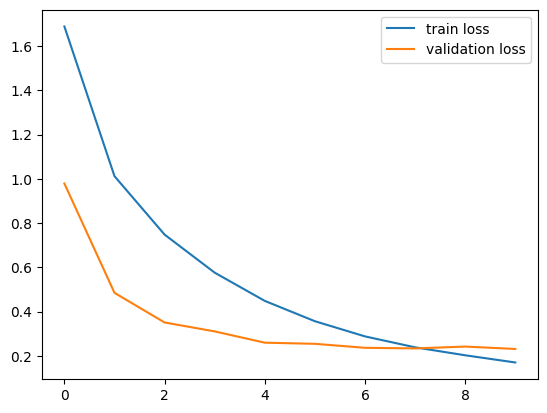

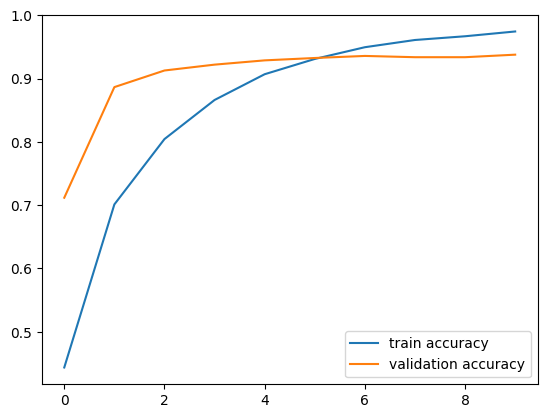

In [ ]:
hist = history

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

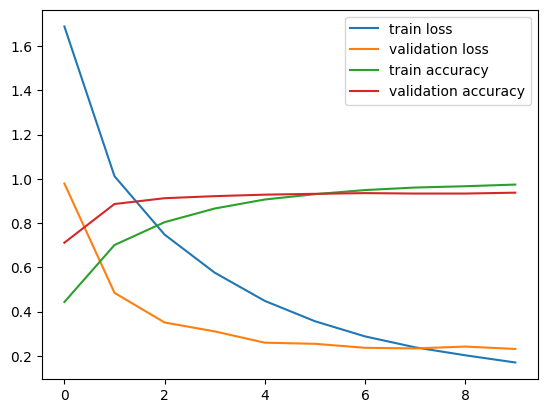

In [ ]:
hist = history

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()